# Face Generation

In this project, I will define and train a DCGAN ([Deep Convolutional Generative Adversarial Network](https://en.wikipedia.org/wiki/Generative_adversarial_network)) on a dataset of celebrity faces. My goal was to get a generator network to generate *new* images of faces that look as realistic as possible. 

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook you could see that the trained generator creates images which like fairly realistic faces with small amounts of noise.

<img src='gan_scheme.jpg' />

### Get the Data

I used the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train my adversarial networks. GPU was utilized for training.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that do not include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=50% />

[This is a zip file](https://drive.google.com/open?id=1WmVUQUUqtgcSC3ErXhGv_IP2POY-fjOB) that you would need to download and extract in the home directory of this notebook for further loading and processing if you would like to reproduce the steps I have performed. After extracting the data, you should be left with a directory  `processed_celeba_small/`

In [1]:
#Commented out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

# Imports
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests 

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since I am going to generate faces, I do not need the annotations and only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

#### ImageFolder

To create a dataset given a directory of images, I have used PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in. I have added a function which returns a DataLoader that shuffles and batches tensor images of size `image_size x image_size` in the x and y dimension.

In [4]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batching the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # data transforms
    data_transforms = transforms.Compose([
        transforms.Resize(image_size), 
        transforms.ToTensor()
    ])

    # get the dataset and the dataloader
    train_dataset = datasets.ImageFolder(data_dir, data_transforms)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader

## Creating a DataLoader

Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces.

In [6]:
# Define function hyperparameters
batch_size = 32
img_size = 32

# Get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

To see square images of somewhat-centered faces, we need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image.

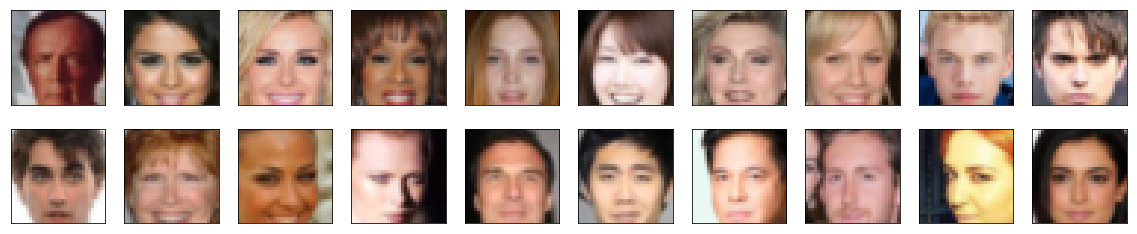

In [7]:
# Helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ is a throwaway variable as we do not need labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

We will be using the [tanh](https://en.wikipedia.org/wiki/Hyperbolic_function#Hyperbolic_tangent) activation function in a generator which will contain pixel values in a range from -1 to 1. Thus, we need to rescale our training images to a range of -1 to 1 (the current range is from 0 to 1).

In [8]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-255.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
# check scaled range 
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9373)
Max:  tensor(0.7412)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Firstly, we will define the discriminator. This is a [convolutional](https://en.wikipedia.org/wiki/Convolutional_neural_network) classifier without any maxpooling layers. To deal with this complex data, we will use a deep network with **normalization**. 

* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


<img src='Conv_1.png' />


We will use [Leaky ReLU](https://en.wikipedia.org/wiki/Activation_function) and [dropout layers](https://en.wikipedia.org/wiki/Dropout_(neural_networks)) to improve the performance of the network. 

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [40]:
# Helper conv function
def conv_seq(input_channels, output_channels, kernel_size, stride=2, padding=1, batch_norm = True):
    layers = []
    conv_layer = nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding, bias = False)
    
    #append convolution layer
    layers.append(conv_layer)
    
    if batch_norm:
        #append batch normalization layer
        layers.append(nn.BatchNorm2d(output_channels))
    
    #return seq layer
    return nn.Sequential(*layers)

In [41]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.kernel_size = 4
        
        # Accept an RGB image as input and output a single value
        
        # 32x32 input : first layer, no normalization 
        self.conv1 = conv_seq(3, conv_dim, self.kernel_size, batch_norm = False)
        # 16x16 output
        self.conv2 = conv_seq(conv_dim, conv_dim*2, self.kernel_size)
        # 8x8 output
        self.conv3 = conv_seq(conv_dim*2, conv_dim*4, self.kernel_size)
        # 4x4 output
        self.conv4 = conv_seq(conv_dim*4, conv_dim*8, self.kernel_size)
        
        #Fully connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)         

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :returns: Discriminator logits; the output of the neural network
        """
        
        # Dropout rate
        dropout_rate = 0.25 
        leaky_alpha = 0.2 # see https://forums.fast.ai/t/dcgan-paper-results/3957/8
        
        # leaky relu applied to all layers but last
        out = F.leaky_relu(self.conv1(x), leaky_alpha)
        out = F.dropout(out, dropout_rate)
        out = F.leaky_relu(self.conv2(out), leaky_alpha)
        out = F.dropout(out, dropout_rate)
        out = F.leaky_relu(self.conv3(out), leaky_alpha)
        out = F.dropout(out, dropout_rate) 
        out = F.leaky_relu(self.conv4(out), leaky_alpha)
        out = F.dropout(out, dropout_rate) 
        
        # flatten output
        out = out.view(-1, self.conv_dim*8*2*2)
        
        # final output layer        
        out = self.fc(out)

        
        '''
        our final output layer should not have any activation function applied to it
        this is because we will be using  BCEWithLogitsLoss, 
        which combines a sigmoid activation function and and binary cross entropy loss in one function
        '''
    
        return out


# Unit tests
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

Here is an exemplary scheme of a generator (note that the dimensions are different from the implementation in this notebook): 

<img src='Conv_2.png' />

In [42]:
#helper deconv_sequential layer function

def deconv_seq(input_channels, output_channels, kernel_size, stride = 2, padding=1, batch_norm = True):
 
    layers = []
    t_conv_layer = nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding, bias = False)
    
    #append transpose conv layer
    layers.append(t_conv_layer)
    
    if batch_norm: #append batch norm layer
        layers.append(nn.BatchNorm2d(output_channels))
    
    return nn.Sequential(*layers)

In [43]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initializing the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        self.kernel_size = 4

        # fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        # transpose convolutional layer 
        self.g_conv1 = deconv_seq(conv_dim*8, conv_dim*4, self.kernel_size)
        self.g_conv2 = deconv_seq(conv_dim*4, conv_dim*2, self.kernel_size)
        self.g_conv3 = deconv_seq(conv_dim*2, conv_dim, self.kernel_size)
        self.g_conv4 = deconv_seq(conv_dim, 3, self.kernel_size, batch_norm = False) #last layer does not need batchnorm
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior

        dropout_rate = 0.25 # a selected constant 

        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.g_conv1(out))
        out = F.dropout(out, dropout_rate)
        out = F.relu(self.g_conv2(out))
        out = F.dropout(out, dropout_rate)
        out = F.relu(self.g_conv3(out))
        out = F.dropout(out, dropout_rate)
        
        #last layer tanh
        out = self.g_conv4(out)
        out = F.tanh(out)
        
        return out

# Unit tests 
tests.test_generator(Generator)

Tests Passed


## Initializing the weights  

To help the models converge, I will initialize the weights of the convolutional and linear layers. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf):
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

I will define a weight initialization function that does exactly this. Note that this should initialize only **convolutional** and **linear** layers. Generally, the bias terms may be left alone or set to 0 if they exist.  

In [44]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # Applying initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv')>=0 or classname.find('Linear')>= 0):
        init.normal_(m.weight.data, 0.0, 0.02)     

## Building a complete network

Next, I am defining my models' hyperparameters and instantiating the discriminator / generator from the classes coded above.  

In [45]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print(G)
    
    return D, G

#### Defining model hyperparameters

In [46]:
# Define model hyperparams
d_conv_dim = img_size
g_conv_dim = img_size
z_size = 100

# Test output 
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (g_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later we will need to make sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [47]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks. If you would like to learn more about how the losses are calculated, here is a [great article](https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/) on this topic. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

We will also apply [smoothing](https://en.wikipedia.org/wiki/Additive_smoothing). 

In [48]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9 #real labels = 1, applying smoothing here
    
    # Move to gpu
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(),labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)   
    
    # Move to gpu
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(),labels)
    
    return loss

## Optimizers

#### Defining optimizers for the Discriminator (D) and Generator (G)

We will define optimizers with appropriate hyperparameters.

In [49]:
import torch.optim as optim

lr = 0.0005   # empirically, a value between 0.0002 and 0.001
b1 = 0.25     # empirically, a value between 0.1 and 0.3
b2 = 0.25

# Optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [b1,b2]) 
g_optimizer = optim.Adam(G.parameters(), lr, [b1,b2])

---
## Training

Training will involve alternating between training the discriminator and the generator. We will use the functions `real_loss` and `fake_loss` to calculate the discriminator losses.

* Discriminator will be trained by alternating on real and fake images
* Generator tries to 'trick' the discriminator so it should have an opposing loss function

In [50]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            # TRAINING THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()  # remove accumulated gradients 
            
            # 1. Train the discriminator on real and fake images
            
            # Train with real images
            if train_on_gpu:
                real_images = real_images.cuda()
            
            real = D(real_images)
            r_loss = real_loss(real)
            
            # Train with fake images
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()
  
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            fake = D(fake_images)
            f_loss = fake_loss(fake)
            
            # Add loss and perform backprop
            d_loss = r_loss + f_loss
            d_loss.backward(retain_graph = True)
            d_optimizer.step()           

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            g_loss = real_loss(fake) #calculate real loss with flipped labels with the z value
            g_loss.backward(retain_graph = True)
            g_optimizer.step()
            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # return losses
    return losses

Let's set the number of training epochs and train the GAN: 

In [52]:
# set number of epochs  
n_epochs = 50

# Call the training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.1372 | g_loss: 0.9430
Epoch [    1/   50] | d_loss: 1.0990 | g_loss: 0.8939
Epoch [    1/   50] | d_loss: 0.5161 | g_loss: 2.6304
Epoch [    1/   50] | d_loss: 0.5735 | g_loss: 2.2990
Epoch [    1/   50] | d_loss: 0.7489 | g_loss: 1.2956
Epoch [    1/   50] | d_loss: 0.3965 | g_loss: 3.5068
Epoch [    1/   50] | d_loss: 0.8816 | g_loss: 3.0800
Epoch [    1/   50] | d_loss: 0.7836 | g_loss: 3.5072
Epoch [    1/   50] | d_loss: 0.6583 | g_loss: 4.1051
Epoch [    1/   50] | d_loss: 0.8995 | g_loss: 1.2556
Epoch [    1/   50] | d_loss: 0.6929 | g_loss: 1.4316
Epoch [    1/   50] | d_loss: 0.6229 | g_loss: 2.8776
Epoch [    1/   50] | d_loss: 0.8715 | g_loss: 1.0652
Epoch [    1/   50] | d_loss: 0.6669 | g_loss: 1.6485
Epoch [    1/   50] | d_loss: 1.2296 | g_loss: 3.5117
Epoch [    1/   50] | d_loss: 1.1399 | g_loss: 0.7595
Epoch [    1/   50] | d_loss: 0.7478 | g_loss: 1.3355
Epoch [    1/   50] | d_loss: 0.4871 | g_loss: 2.2402
Epoch [    1/   50] | d_loss

## Training loss

Now let's plot the training losses for the generator and discriminator, recorded after each epoch.

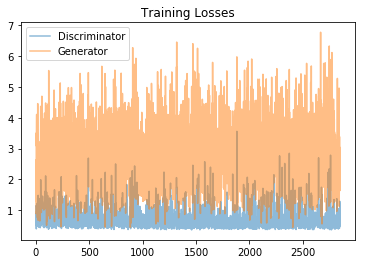

In [53]:
fig, ax = plt.subplots()  
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

On the first glance, if you do not know the theory behing GAN, this looks like the networks are not even trained because the loss oscillates a lot. What is happening here is that a Generator is constantly learning to reshape the random vector so that it looks like a real image, while Discriminator becomes better and better in recognizing fakes. This is why the loss graph looks like this. 

## Generator samples from training

Let's check the actual samples: 

In [54]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [55]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

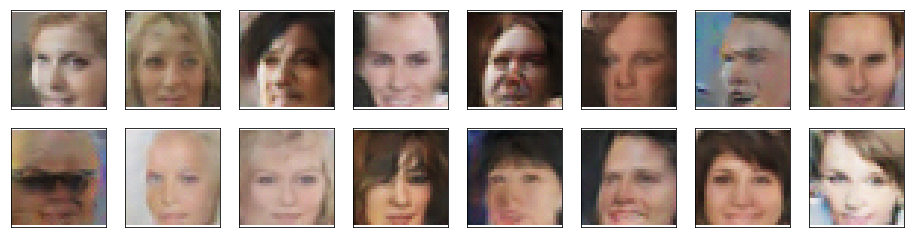

In [56]:
_ = view_samples(-1, samples)

**Notes:** 

- Number of epochs and learning rate have affected the results significantly. I have started with only 15 epochs and then increased the number of epochs to 50. The outcome has improved drastically. Also, lowering the learning rate helped. 
- I started with only 3 convolutional layers and then added one more as I was not satisfied with the initial outcomes. 4 layers perform visibly better. 
- The dataset is indeed biased because the majority of generated faces are women's. 
- It was interesting to observe how the beta of β1, β2 of 0.25 performs better than β1 = 0.5, β2 = 0.999 from the original GAN paper. 